In [424]:
%pip install pandas seaborn matplotlib scikit-learn nltk xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [425]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import joblib

Feature Loading and Evaluation Setup

In [426]:
# Project root directory
PROJECT_ROOT = Path.cwd().parent

# Folder containing extracted feature
FEATURES_ROOT = PROJECT_ROOT / "features"

# Folder used to store trained models
MODELS_ROOT = PROJECT_ROOT / "models"
MODELS_ROOT.mkdir(parents=True, exist_ok=True)

# Folder used to store evaluation figures
FIGURES_DIR = PROJECT_ROOT / "figures" / "training_and_evaluation"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Selected embedding type for this run
# Options: "tf-idf", "tf-idf-lsa", "vector-embeddings"
EMBEDDING = "tf-idf-lsa"
emb_dir = FEATURES_ROOT / EMBEDDING

# Container for storing final model results
results = []

# Load labels
y = np.load(emb_dir / "labels.npy").ravel()

# Feature files (dense or sparse)
features_npy = emb_dir / "features.npy"
features_npz = emb_dir / "features.npz"

# Load feature matrix
if features_npy.exists():
    X = np.load(features_npy, allow_pickle=True)
else:
    from scipy.sparse import load_npz
    X = load_npz(features_npz).tocsr()

print("X:", X.shape, "y:", y.shape)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)


def save_model(model, model_name: str):
    """Save a trained ML model"""
    path = MODELS_ROOT / f"{model_name}_{EMBEDDING}.joblib"
    joblib.dump(model, path)
    print(f"Saved: {path}")


def save_current_figure(plot_name: str, dpi=300):
    """Save the current figure."""
    path = FIGURES_DIR / f"{plot_name}_{EMBEDDING}.png"
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved plot: {path}")


def log_result(model_name: str, category: str, accuracy: float):
    """Store model accuracy for comparison."""
    results.append({
        "Model": model_name,
        "Category": category, # ML or DL
        "Embedding": EMBEDDING,
        "Accuracy": accuracy
    })


X: (9987, 100) y: (9987,)
Train: (7989, 100) (7989,)
Test:  (1998, 100) (1998,)


In [427]:
def eval_result(y_test, pred, proba=None, model_name="model"):
    acc = accuracy_score(y_test, pred)

    print(classification_report(y_test, pred, target_names=["Ham", "Spam"]))
    print(f"Accuracy: {acc:.5f}")

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        confusion_matrix(y_test, pred),
        annot=True,
        fmt="d",
        cmap=sns.color_palette("Reds", 50)
    )
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.title(f"Confusion Matrix - {model_name}")
    save_current_figure(f"confusion_matrix_{model_name}")
    plt.show()
    plt.close()

    # PR curve
    if proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, proba)
        plt.figure(figsize=(6, 6))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR Curve - {model_name}")
        save_current_figure(f"pr_curve_{model_name}")
        plt.show()
        plt.close()

    return acc

ML MODELS


Naive Bayes

Saved: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/naive_bayes_tf-idf-lsa.joblib
              precision    recall  f1-score   support

         Ham       0.82      0.90      0.86      1059
        Spam       0.88      0.78      0.83       939

    accuracy                           0.85      1998
   macro avg       0.85      0.84      0.84      1998
weighted avg       0.85      0.85      0.84      1998

Accuracy: 0.84535
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_naive_bayes_tf-idf-lsa.png


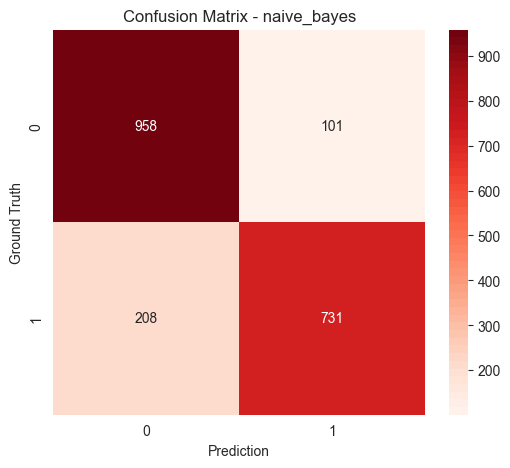

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_naive_bayes_tf-idf-lsa.png


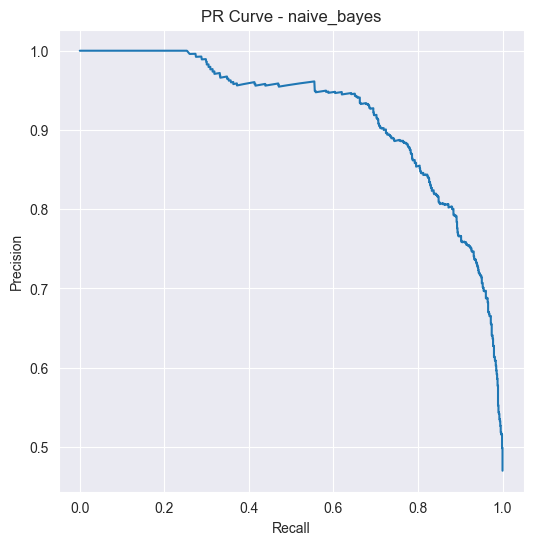

In [428]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

if EMBEDDING == "tf-idf":
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_test)
    nb_proba = nb.predict_proba(X_test)[:, 1]

else:  # tf-idf-lsa or vector-embeddings
    nb = GaussianNB()
    X_train_nb = X_train.toarray() if hasattr(X_train, "toarray") else X_train
    X_test_nb  = X_test.toarray()  if hasattr(X_test, "toarray")  else X_test

    nb.fit(X_train_nb, y_train)
    nb_pred = nb.predict(X_test_nb)
    nb_proba = nb.predict_proba(X_test_nb)[:, 1]


save_model(nb, "naive_bayes")
acc = eval_result(y_test, nb_pred, nb_proba, model_name="naive_bayes")
log_result("Naive Bayes", "ML", acc)

Logistic Regression

Saved: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/logistic_regression_tf-idf-lsa.joblib
              precision    recall  f1-score   support

         Ham       0.95      0.96      0.95      1059
        Spam       0.95      0.94      0.95       939

    accuracy                           0.95      1998
   macro avg       0.95      0.95      0.95      1998
weighted avg       0.95      0.95      0.95      1998

Accuracy: 0.95195
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_logistic_regression_tf-idf-lsa.png


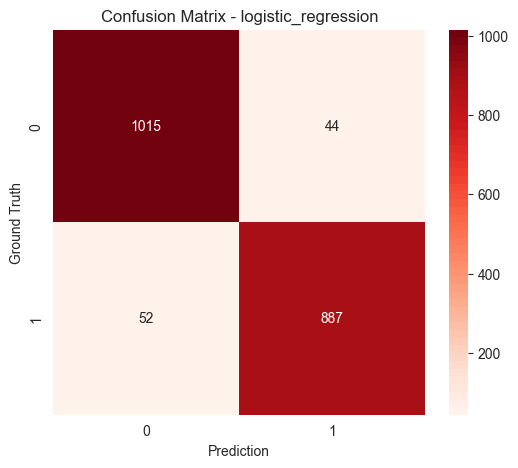

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_logistic_regression_tf-idf-lsa.png


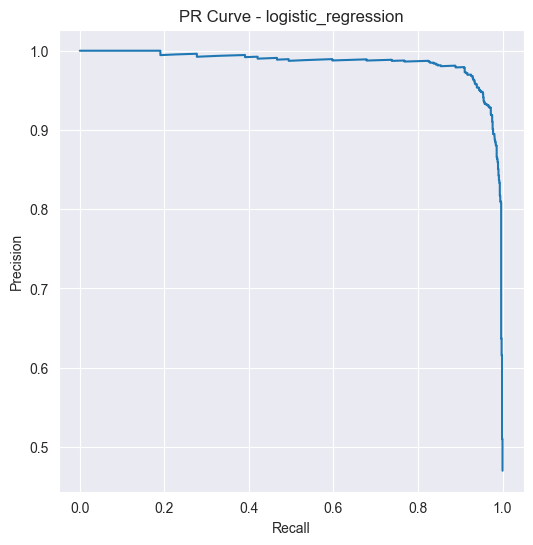

In [429]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:, 1]

save_model(lr, "logistic_regression")
acc = eval_result(y_test, lr_pred, lr_proba, model_name="logistic_regression")
log_result("Logistic Regression", "ML", acc)

SVM

Saved: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/svm_tf-idf-lsa.joblib
              precision    recall  f1-score   support

         Ham       0.97      0.98      0.98      1059
        Spam       0.98      0.97      0.97       939

    accuracy                           0.97      1998
   macro avg       0.98      0.97      0.97      1998
weighted avg       0.97      0.97      0.97      1998

Accuracy: 0.97497
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_svm_tf-idf-lsa.png


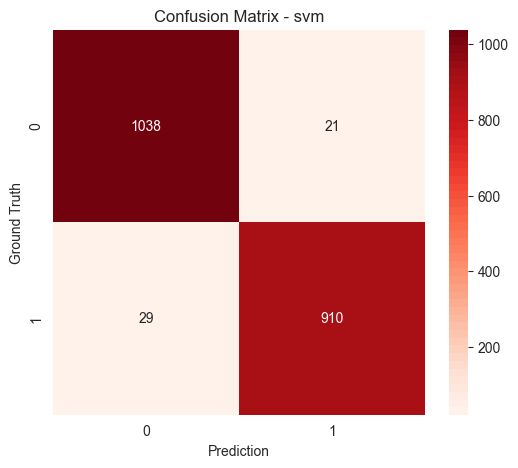

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_svm_tf-idf-lsa.png


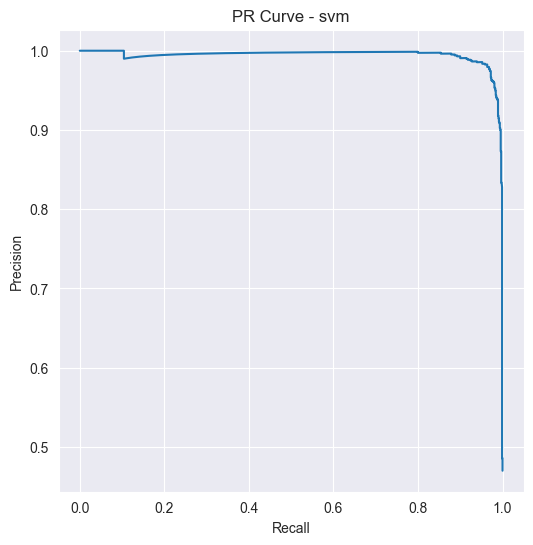

In [430]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)
svm_proba = svm.predict_proba(X_test)[:, 1]

save_model(svm, "svm")
acc = eval_result(y_test, svm_pred, svm_proba, model_name="svm")
log_result("SVM", "ML", acc)

K-nearest Neighbors

Saved: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/knn_tf-idf-lsa.joblib
              precision    recall  f1-score   support

         Ham       0.94      0.98      0.96      1059
        Spam       0.98      0.93      0.95       939

    accuracy                           0.96      1998
   macro avg       0.96      0.96      0.96      1998
weighted avg       0.96      0.96      0.96      1998

Accuracy: 0.95746
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_knn_tf-idf-lsa.png


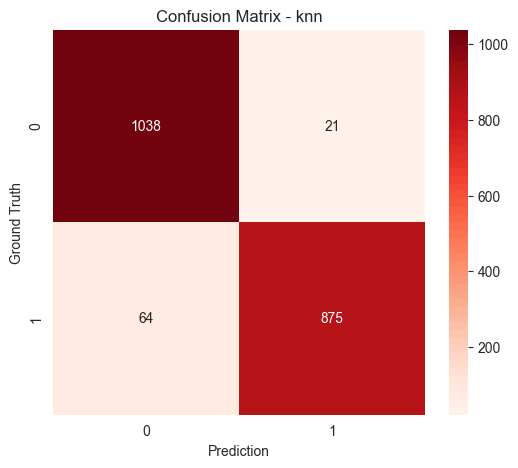

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_knn_tf-idf-lsa.png


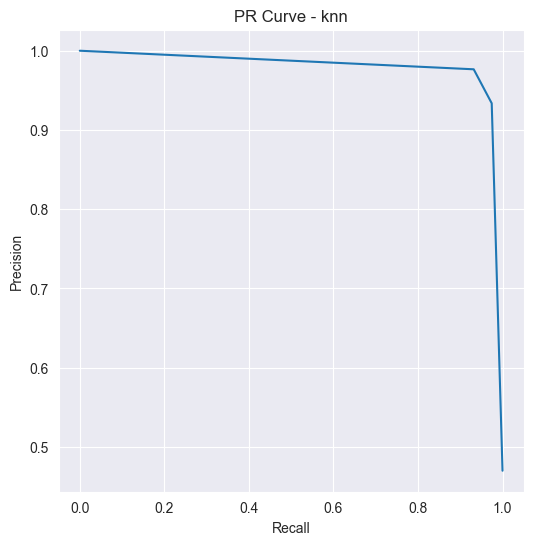

In [431]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

knn_pred  = knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)[:, 1]

save_model(knn, "knn")
acc = eval_result(y_test, knn_pred, knn_proba, model_name="knn")
log_result("KNN", "ML", acc)

Random Forest

Saved: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/random_forest_tf-idf-lsa.joblib
              precision    recall  f1-score   support

         Ham       0.95      0.98      0.97      1059
        Spam       0.98      0.95      0.96       939

    accuracy                           0.96      1998
   macro avg       0.97      0.96      0.96      1998
weighted avg       0.96      0.96      0.96      1998

Accuracy: 0.96396
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_random_forest_tf-idf-lsa.png


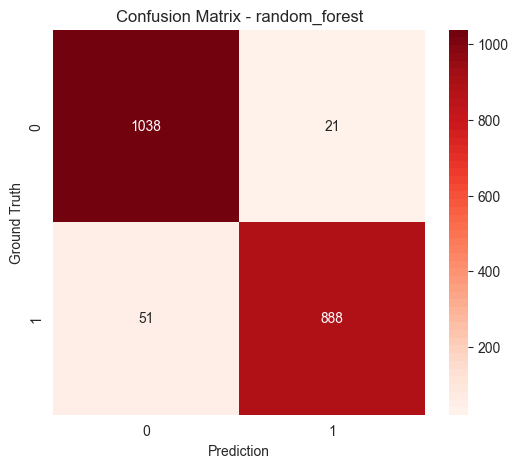

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_random_forest_tf-idf-lsa.png


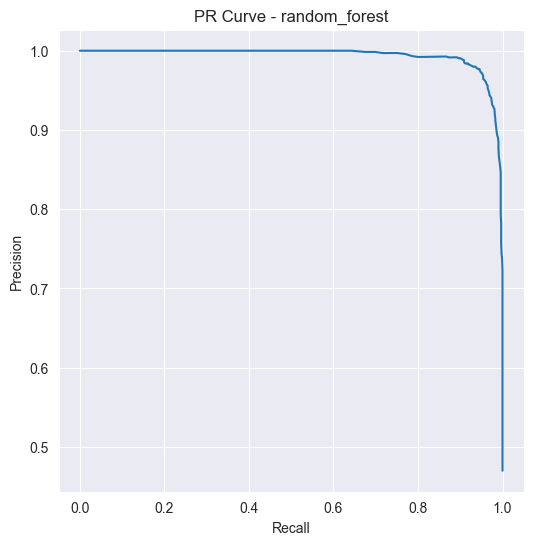

In [432]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

rf_pred  = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

save_model(rf, "random_forest")
acc = eval_result(y_test, rf_pred, rf_proba, model_name="random_forest")
log_result("Random Forest", "ML", acc)

XGBoost

Saved: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/xgboost_tf-idf-lsa.joblib
              precision    recall  f1-score   support

         Ham       0.97      0.98      0.97      1059
        Spam       0.98      0.96      0.97       939

    accuracy                           0.97      1998
   macro avg       0.97      0.97      0.97      1998
weighted avg       0.97      0.97      0.97      1998

Accuracy: 0.96997
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_xgboost_tf-idf-lsa.png


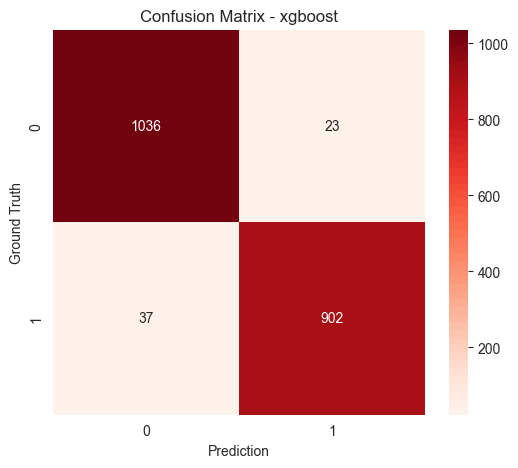

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_xgboost_tf-idf-lsa.png


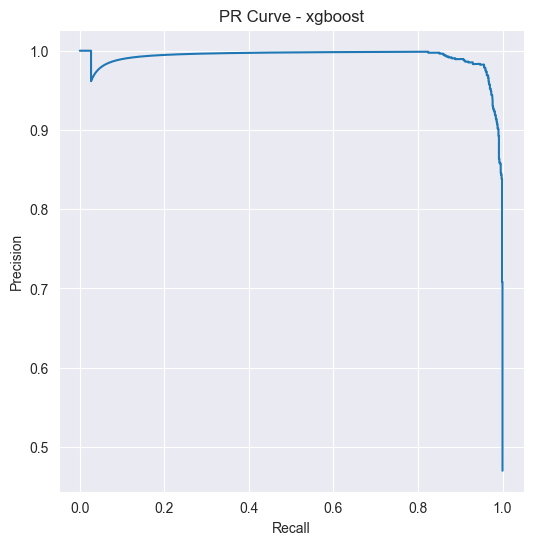

In [433]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb.fit(X_train, y_train)

xgb_pred  = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]

save_model(xgb, "xgboost")
acc = eval_result(y_test, xgb_pred, xgb_proba, model_name="xgboost")
log_result("XGBoost", "ML", acc)

DEEP LEARNING MODELS

In [434]:
%pip install -q tensorflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [435]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

Helpers

In [436]:
def to_dense(X):
    """Convert sparse matrices to dense arrays."""
    return X.toarray() if hasattr(X, "toarray") else np.asarray(X)

def save_keras_model(model, model_name: str):
    """Save a trained deep learning model."""
    path = MODELS_ROOT / f"{model_name}_{EMBEDDING}.keras"
    model.save(path)
    print(f"Saved DL model: {path}")

def plot_and_save_history(history, model_name: str):
    """Plot and save the training/validation loss curve."""
    plt.figure(figsize=(7, 4))
    plt.plot(history.history["loss"], label="train_loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Curve - {model_name}")
    plt.legend()
    save_current_figure(f"training_curve_{model_name}")
    plt.show()
    plt.close()

def train_eval_dl(model, model_name: str, Xtr, ytr, Xte, yte):
    """Train, evaluate, save, and log a deep learning model."""
    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )

    history = model.fit(
        Xtr, ytr,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[es],
        verbose=1
    )

    plot_and_save_history(history, model_name)
    save_keras_model(model, model_name)

    proba = model.predict(Xte, verbose=0).ravel()
    pred = (proba >= 0.5).astype(int)

    acc = eval_result(yte, pred, proba, model_name=model_name)
    log_result(model_name.upper(), "DL", acc)



# Prepare labels
y_train_dl = np.asarray(y_train).astype(int).ravel()
y_test_dl  = np.asarray(y_test).astype(int).ravel()

# Convert feature matrices to dense format for Keras
X_train_dl = to_dense(X_train)
X_test_dl  = to_dense(X_test)

Deep Learning Model Architectures

In [437]:
def build_mlp(input_dim: int):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(512)(inp)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_lstm(timesteps: int):
    inp = layers.Input(shape=(timesteps, 1))
    x = layers.LSTM(64)(inp)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn(timesteps: int):
    inp = layers.Input(shape=(timesteps, 1))
    x = layers.Conv1D(filters=32, kernel_size=3)(inp)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_lstm(timesteps: int):
    inp = layers.Input(shape=(timesteps, 1))
    x = layers.Conv1D(filters=32, kernel_size=3)(inp)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(64)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_gru(timesteps: int):
    inp = layers.Input(shape=(timesteps, 1))
    x = layers.GRU(64)(inp)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model



Model Selection Based on Embedding Type

[DL] Using sequence models for tf-idf-lsa. Timesteps/features: 100
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5348 - loss: 0.6910 - val_accuracy: 0.5144 - val_loss: 0.6935
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5339 - loss: 0.6900 - val_accuracy: 0.5219 - val_loss: 0.6906
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5378 - loss: 0.6871 - val_accuracy: 0.5144 - val_loss: 0.6857
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5716 - loss: 0.6654 - val_accuracy: 0.6245 - val_loss: 0.6388
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6520 - loss: 0.6263 - val_accuracy: 0.6821 - val_loss: 0.6096
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6775 - loss: 0.6090 - val_accuracy: 0.6965 - val_loss: 0.5936
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6860 - loss: 0.5852 - val_accuracy: 0.7278 - val_loss: 0.5546
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32m

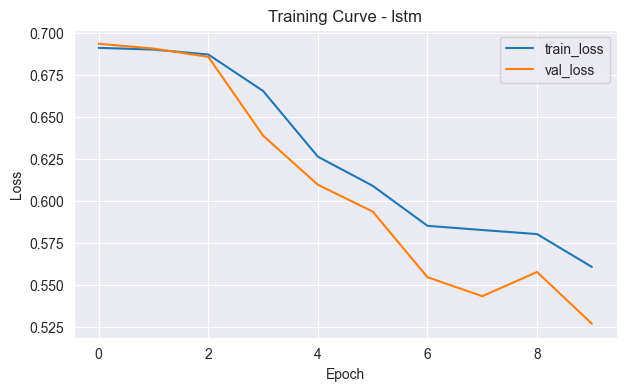

Saved DL model: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/lstm_tf-idf-lsa.keras
              precision    recall  f1-score   support

         Ham       0.77      0.74      0.75      1059
        Spam       0.72      0.74      0.73       939

    accuracy                           0.74      1998
   macro avg       0.74      0.74      0.74      1998
weighted avg       0.74      0.74      0.74      1998

Accuracy: 0.74124
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_lstm_tf-idf-lsa.png


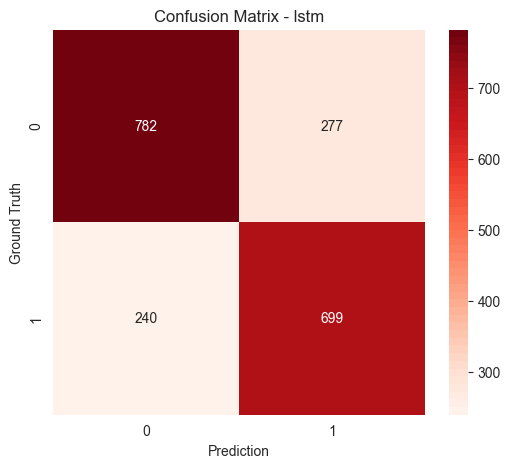

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_lstm_tf-idf-lsa.png


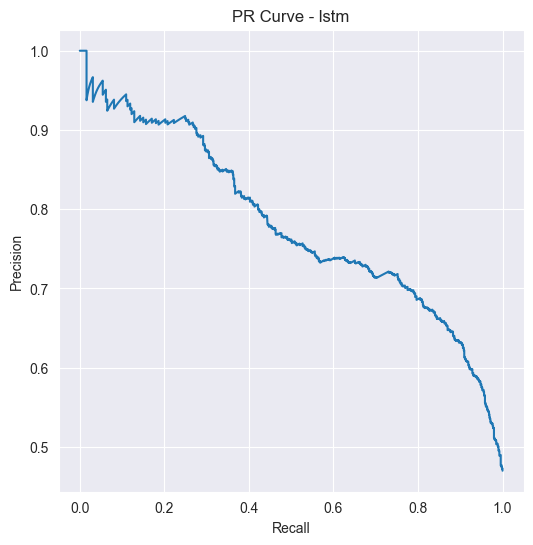

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5724 - loss: 0.6636 - val_accuracy: 0.6640 - val_loss: 0.6376
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7000 - loss: 0.6008 - val_accuracy: 0.8035 - val_loss: 0.5635
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8223 - loss: 0.5192 - val_accuracy: 0.8611 - val_loss: 0.4760
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8636 - loss: 0.4368 - val_accuracy: 0.8673 - val_loss: 0.4015
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8775 - loss: 0.3715 - val_accuracy: 0.8905 - val_loss: 0.3451
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8991 - loss: 0.3209 - val_accuracy: 0.9105 - val_loss: 0.3030
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9207 - loss: 0.2836 - val_accuracy: 0.9337 - val_loss: 0.2703
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9354 - loss: 0.2550 - val_accuracy: 0.9374 - val_loss:

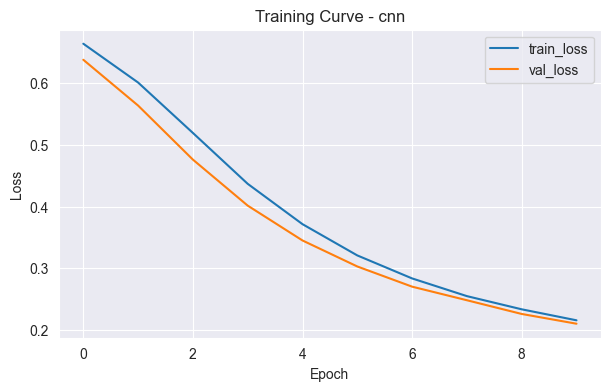

Saved DL model: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/cnn_tf-idf-lsa.keras
              precision    recall  f1-score   support

         Ham       0.94      0.95      0.95      1059
        Spam       0.95      0.93      0.94       939

    accuracy                           0.94      1998
   macro avg       0.94      0.94      0.94      1998
weighted avg       0.94      0.94      0.94      1998

Accuracy: 0.94144
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_cnn_tf-idf-lsa.png


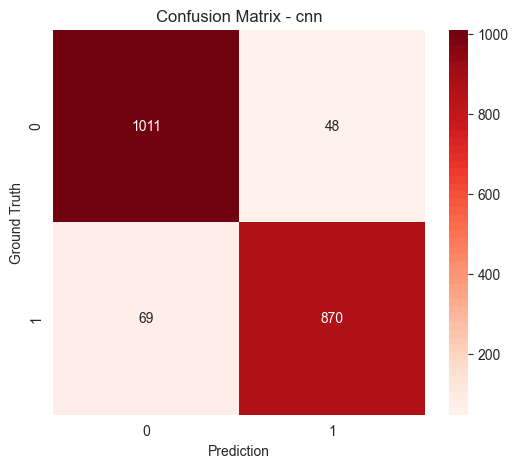

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_cnn_tf-idf-lsa.png


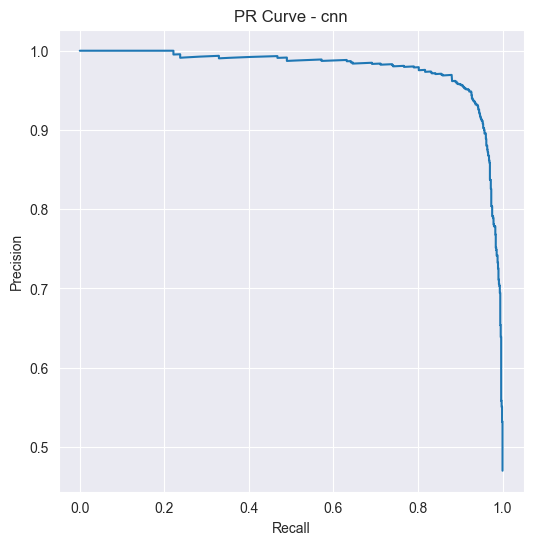

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5675 - loss: 0.6824 - val_accuracy: 0.6126 - val_loss: 0.6731
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6257 - loss: 0.6555 - val_accuracy: 0.6302 - val_loss: 0.6457
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6356 - loss: 0.6411 - val_accuracy: 0.6646 - val_loss: 0.6371
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6622 - loss: 0.6286 - val_accuracy: 0.6758 - val_loss: 0.6218
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6747 - loss: 0.6050 - val_accuracy: 0.6840 - val_loss: 0.5867
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7094 - loss: 0.5604 - val_accuracy: 0.6627 - val_loss: 0.5889
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7220 - loss: 0.5443 - val_accuracy: 0.6902 - val_loss: 0.6132
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/train

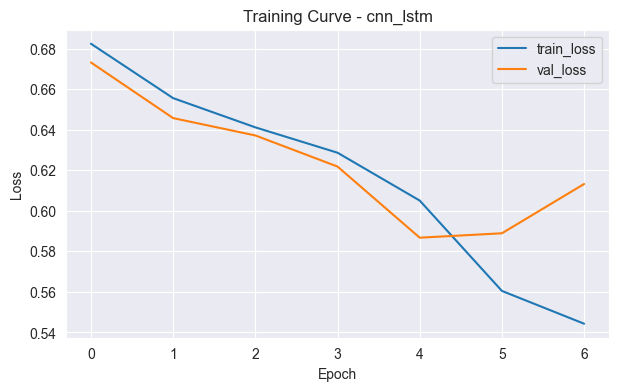

Saved DL model: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/cnn_lstm_tf-idf-lsa.keras
              precision    recall  f1-score   support

         Ham       0.75      0.59      0.66      1059
        Spam       0.63      0.78      0.70       939

    accuracy                           0.68      1998
   macro avg       0.69      0.69      0.68      1998
weighted avg       0.69      0.68      0.68      1998

Accuracy: 0.67918
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_cnn_lstm_tf-idf-lsa.png


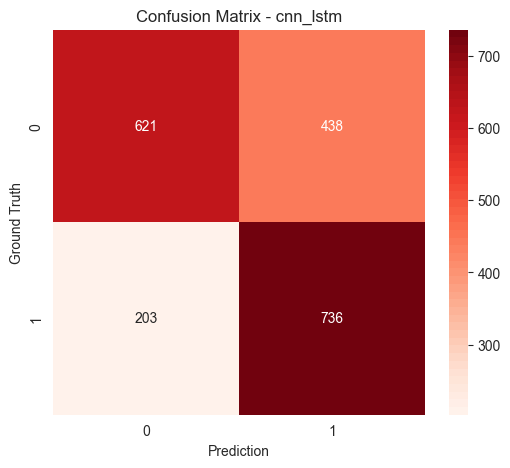

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_cnn_lstm_tf-idf-lsa.png


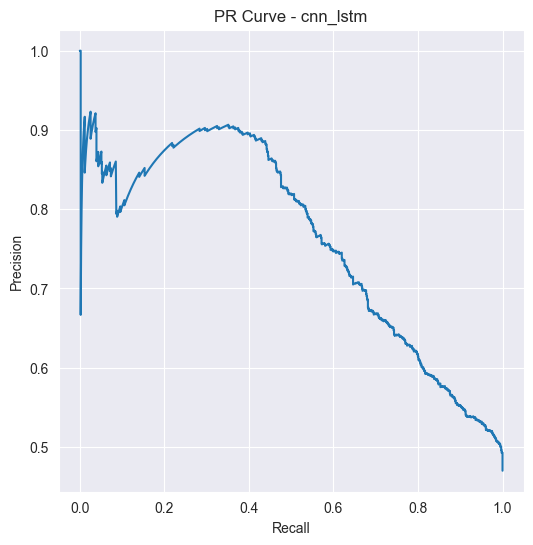

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5315 - loss: 0.6904 - val_accuracy: 0.5144 - val_loss: 0.6915
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5373 - loss: 0.6864 - val_accuracy: 0.5013 - val_loss: 0.6826
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5473 - loss: 0.6725 - val_accuracy: 0.6064 - val_loss: 0.6668
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5875 - loss: 0.6652 - val_accuracy: 0.6126 - val_loss: 0.6565
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5805 - loss: 0.6662 - val_accuracy: 0.6101 - val_loss: 0.6565
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5891 - loss: 0.6661 - val_accuracy: 0.6101 - val_loss: 0.6618
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/training_curve_gru_tf-idf-lsa.png


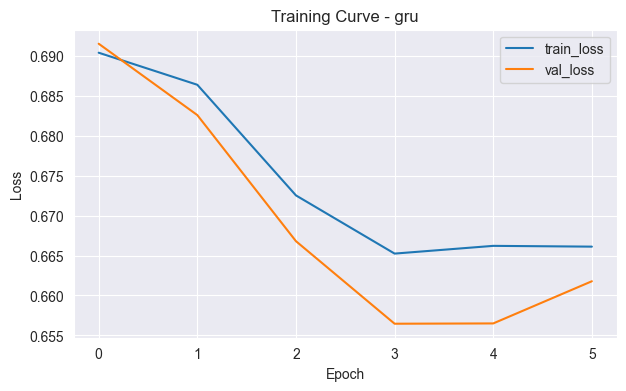

Saved DL model: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/models/gru_tf-idf-lsa.keras
              precision    recall  f1-score   support

         Ham       0.63      0.62      0.62      1059
        Spam       0.58      0.59      0.58       939

    accuracy                           0.60      1998
   macro avg       0.60      0.60      0.60      1998
weighted avg       0.60      0.60      0.60      1998

Accuracy: 0.60360
Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/confusion_matrix_gru_tf-idf-lsa.png


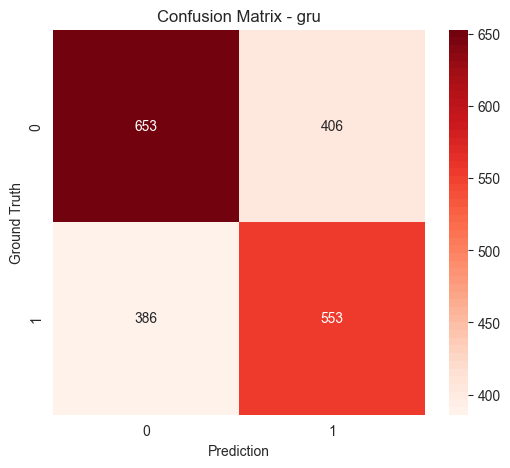

Saved plot: /Users/crisztina.zudor/PycharmProjects/ML2-SMS-Spam-Detection/figures/training_and_evaluation/pr_curve_gru_tf-idf-lsa.png


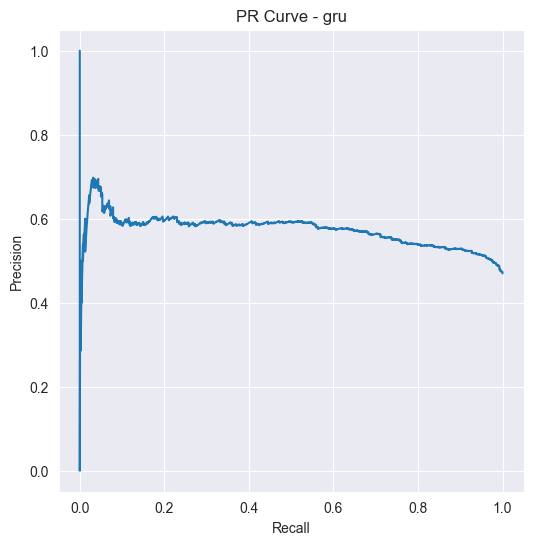

In [438]:
if EMBEDDING == "tf-idf":
    # MLP on flat features
    input_dim = X_train_dl.shape[1]
    print(f"[DL] Using MLP for TF-IDF. Input dim: {input_dim}")

    mlp = build_mlp(input_dim)
    train_eval_dl(mlp, "mlp", X_train_dl, y_train_dl, X_test_dl, y_test_dl)

elif EMBEDDING in {"tf-idf-lsa", "vector-embeddings"}:
    # sequence reshape: (N, F) -> (N, F, 1)
    X_train_seq = X_train_dl[..., None]
    X_test_seq  = X_test_dl[..., None]
    timesteps = X_train_seq.shape[1]
    print(f"[DL] Using sequence models for {EMBEDDING}. Timesteps/features: {timesteps}")

    lstm_model = build_lstm(timesteps)
    train_eval_dl(lstm_model, "lstm", X_train_seq, y_train_dl, X_test_seq, y_test_dl)

    cnn_model = build_cnn(timesteps)
    train_eval_dl(cnn_model, "cnn", X_train_seq, y_train_dl, X_test_seq, y_test_dl)

    cnn_lstm_model = build_cnn_lstm(timesteps)
    train_eval_dl(cnn_lstm_model, "cnn_lstm", X_train_seq, y_train_dl, X_test_seq, y_test_dl)

    gru_model = build_gru(timesteps)
    train_eval_dl(gru_model, "gru", X_train_seq, y_train_dl, X_test_seq, y_test_dl)

else:
    raise ValueError(f"Unknown EMBEDDING: {EMBEDDING}")

MODEL PERFORMANCE COMPARISON

In [439]:
results_df = pd.DataFrame(results)

# Sort by accuracy (highest first)
results_df = (
    results_df
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)

# Make index start from 1 instead of 0
results_df.index = results_df.index + 1

display(results_df)

PERFORMANCE_DIR = PROJECT_ROOT / "model_performance"
PERFORMANCE_DIR.mkdir(parents=True, exist_ok=True)

# Save results table
results_df.to_csv(
    PERFORMANCE_DIR / f"model_comparison_{EMBEDDING}.csv",
    index=True  # keep the 1-based index
)

print("Table saved")


,Model,Category,Embedding,Accuracy
1,SVM,ML,tf-idf-lsa,0.974975
2,XGBoost,ML,tf-idf-lsa,0.969970
3,Random Forest,ML,tf-idf-lsa,0.963964
4,KNN,ML,tf-idf-lsa,0.957457
5,Logistic Regression,ML,tf-idf-lsa,0.951952
6,CNN,DL,tf-idf-lsa,0.941441
7,Naive Bayes,ML,tf-idf-lsa,0.845345
8,LSTM,DL,tf-idf-lsa,0.741241
9,CNN_LSTM,DL,tf-idf-lsa,0.679179
10,GRU,DL,tf-idf-lsa,0.603604


Table saved
